# Data extraction and aggregation

In [17]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

path = r'./UNSW-NB15/'

features = pd.read_csv(path + "NUSW-NB15_features.csv", encoding='cp1252')

data = pd.concat([
    pd.read_csv(path + "UNSW-NB15_1.csv", low_memory=False, names=features.Name),
    pd.read_csv(path + "UNSW-NB15_2.csv", low_memory=False, names=features.Name),
    pd.read_csv(path + "UNSW-NB15_3.csv", low_memory=False, names=features.Name),
    pd.read_csv(path + "UNSW-NB15_4.csv", low_memory=False, names=features.Name)
])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  Sload             float64
 15  Dload             float64
 16  Spkts             int64  
 17  Dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  Sjit           

# Features Conversion

## Features which are unusable in the real world are dropped

the features are : `srcip`, `sport`, `dstip`

ip and port can vary and they can be faked using vpns

In [18]:
data.drop(
	columns=["srcip", "sport", "dstip"], 
	inplace=True
)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 46 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dsport            object 
 1   proto             object 
 2   state             object 
 3   dur               float64
 4   sbytes            int64  
 5   dbytes            int64  
 6   sttl              int64  
 7   dttl              int64  
 8   sloss             int64  
 9   dloss             int64  
 10  service           object 
 11  Sload             float64
 12  Dload             float64
 13  Spkts             int64  
 14  Dpkts             int64  
 15  swin              int64  
 16  dwin              int64  
 17  stcpb             int64  
 18  dtcpb             int64  
 19  smeansz           int64  
 20  dmeansz           int64  
 21  trans_depth       int64  
 22  res_bdy_len       int64  
 23  Sjit              float64
 24  Djit              float64
 25  Stime             int64  
 26  Ltime          

## Parsing `ct_ftp_cmd` to int

setting `-1` if the value was blank

In [19]:
data["ct_ftp_cmd"] = data["ct_ftp_cmd"].apply(lambda x: int(x) if x != " " else -1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 46 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dsport            object 
 1   proto             object 
 2   state             object 
 3   dur               float64
 4   sbytes            int64  
 5   dbytes            int64  
 6   sttl              int64  
 7   dttl              int64  
 8   sloss             int64  
 9   dloss             int64  
 10  service           object 
 11  Sload             float64
 12  Dload             float64
 13  Spkts             int64  
 14  Dpkts             int64  
 15  swin              int64  
 16  dwin              int64  
 17  stcpb             int64  
 18  dtcpb             int64  
 19  smeansz           int64  
 20  dmeansz           int64  
 21  trans_depth       int64  
 22  res_bdy_len       int64  
 23  Sjit              float64
 24  Djit              float64
 25  Stime             int64  
 26  Ltime          

## Converting Hex to int

In [20]:
data["dsport"] = data["dsport"].apply(lambda x: int(x, 16) if x != "-" else -1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 46 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dsport            int64  
 1   proto             object 
 2   state             object 
 3   dur               float64
 4   sbytes            int64  
 5   dbytes            int64  
 6   sttl              int64  
 7   dttl              int64  
 8   sloss             int64  
 9   dloss             int64  
 10  service           object 
 11  Sload             float64
 12  Dload             float64
 13  Spkts             int64  
 14  Dpkts             int64  
 15  swin              int64  
 16  dwin              int64  
 17  stcpb             int64  
 18  dtcpb             int64  
 19  smeansz           int64  
 20  dmeansz           int64  
 21  trans_depth       int64  
 22  res_bdy_len       int64  
 23  Sjit              float64
 24  Djit              float64
 25  Stime             int64  
 26  Ltime          

## Setting `Nan` to `-1`

In [21]:
data["ct_flw_http_mthd"].fillna(-1,  inplace=True)
data["is_ftp_login"].fillna(-1,  inplace=True)


## Converting the nominal features

todo: create the enum for each features

In [22]:
nominal_features = ["proto", "state", "service"]

for nominal_feature in nominal_features:
		new_values, index = pd.factorize(data[nominal_feature])
		data[nominal_feature] = new_values

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 46 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dsport            int64  
 1   proto             int64  
 2   state             int64  
 3   dur               float64
 4   sbytes            int64  
 5   dbytes            int64  
 6   sttl              int64  
 7   dttl              int64  
 8   sloss             int64  
 9   dloss             int64  
 10  service           int64  
 11  Sload             float64
 12  Dload             float64
 13  Spkts             int64  
 14  Dpkts             int64  
 15  swin              int64  
 16  dwin              int64  
 17  stcpb             int64  
 18  dtcpb             int64  
 19  smeansz           int64  
 20  dmeansz           int64  
 21  trans_depth       int64  
 22  res_bdy_len       int64  
 23  Sjit              float64
 24  Djit              float64
 25  Stime             int64  
 26  Ltime          

# Data reduction

## Binary classication distributioon

In [23]:
data_summary_attack = pd.DataFrame(data.Label.value_counts())
data_summary_attack.columns.values[0] = "Occurrencies"

data_summary_attack["Percentage"] = data.Label.value_counts() / len(data)

data_summary_attack

,Occurrencies,Percentage
0,2218764,0.873513
1,321283,0.126487


We have a very unbalanced dataset. Now let's look at the attack classes

## Multiclass classificatin distribution

In [24]:

data_summary_classes = pd.DataFrame(data.attack_cat.value_counts())
data_summary_classes.columns.values[0] = "Occurrencies"

attack_len = sum(data.Label)
data_summary_classes["Percentage"] = data.attack_cat.value_counts() / attack_len

data_summary_classes

,Occurrencies,Percentage
Generic,215481,0.670689
Exploits,44525,0.138585
Fuzzers,19195,0.059745
DoS,16353,0.050899
Reconnaissance,12228,0.038060
Fuzzers,5051,0.015721
Analysis,2677,0.008332
Backdoor,1795,0.005587
Reconnaissance,1759,0.005475
Shellcode,1288,0.004009


also the classes of attack are very unbalanced

## Reduce the number of classes of attack

data is clustered using k-means

<Figure size 640x480 with 0 Axes>

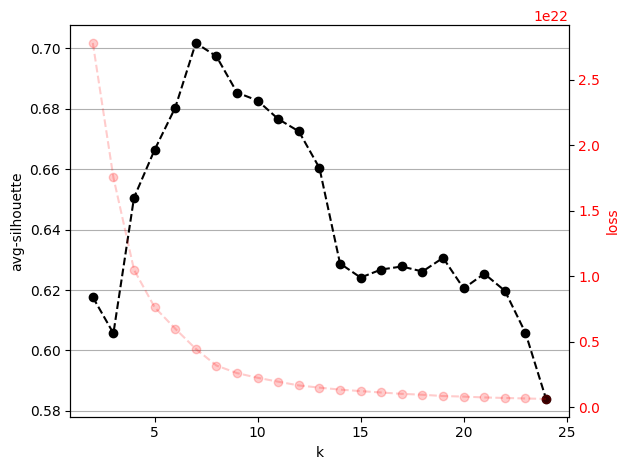

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

to_plot = data.drop(columns=["Label", "attack_cat"]).sample(20_000)

silhouette_list = []
inertia_list=[]
# f,axes = plt.subplots(2,4,figsize = (20,10))

for n_clusters in range(2,25):
    kmeans = KMeans(n_clusters=n_clusters, random_state=10, init="k-means++")
    y_pred = kmeans.fit_predict(to_plot)

    # evaluate silhouette score
    silhouetteavg = silhouette_score(to_plot,y_pred)
    silhouette_list.append(silhouetteavg)

    # evaluate inertia
    inertia_list.append(kmeans.inertia_)

    # display clustered samples
    # axes[(n_clusters-2)//4][(n_clusters-2)%4].scatter(to_plot[:,0],to_plot[:,1], c = y_pred,alpha = 0.5)
    # axes[(n_clusters-2)//4][(n_clusters-2)%4].axis('equal')
    # axes[(n_clusters-2)//4][(n_clusters-2)%4].set_xlabel('Feature 1')
    # axes[(n_clusters-2)//4][(n_clusters-2)%4].set_ylabel('Feature 2')
    # axes[(n_clusters-2)//4][(n_clusters-2)%4].set_title(f'k={n_clusters} - Avg. Silhouette={silhouetteavg:.2} - n_iter = {kmeans.niter}' )

    # display clusters centroids
    centers = kmeans.cluster_centers_
    # axes[(n_clusters-2)//4][(n_clusters-2)%4].scatter(centers[:,0],centers[:,1], marker = 'x',c = 'r')

plt.tight_layout()

# plot silhouette and inertia trends w.r.t the number of clusters
fig, ax1 = plt.subplots()
ax1.set_xlabel('k')
ax1.set_ylabel('avg-silhouette', color='black')
ax1.plot(range(2,25),silhouette_list,'--ok')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('loss', color='red')
ax2.plot(range(2,25), inertia_list,'--or',alpha = 0.2)
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()  # otherwise the right y-label is slightly clipped

then we will determine the right amount of clusters by using the silhouette method

then from each cluster we will select the predominat class of attack

we can see that the classes of attack are reduced to ...

## Plot the features correlation

In [ ]:
f,ax = plt.subplots(figsize=(40,32))

data_without_label = data.drop(columns=['Label'])

correlation_matrix = data_without_label.corr()

sns.heatmap(correlation_matrix, annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

Drop the correlated features

In [ ]:
import numpy as np

abs_correlation_matrix = correlation_matrix.abs()

# Select upper triangle of correlation matrix
upper = abs_correlation_matrix.where(np.triu(np.ones(abs_correlation_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

print(to_drop)

# Drop features 
data.drop(to_drop, axis=1, inplace=True)

data.info()

## Information gain

each features is analized to determine which features are not useful

# Analyze the predominant features distributions

ex: if `unas` is used only to do attacks there is a real world problem, beacuse every time you use `unas` the classificator detects it as an attack

below we are cheking for the `proto` features 

In [ ]:
data_summary_protocol = pd.DataFrame(data.proto)
data_summary_protocol.dropna(how="all")
data_summary_protocol = data_summary_protocol.reset_index().groupby("proto").count()
data_summary_protocol.columns.values[0] = "Occurrencies"
data_summary_protocol["Percentage"] = data_summary_protocol.Occurrencies/data_summary_protocol.sum()[0]
data_summary_protocol.sort_values('Occurrencies', ascending=False)

We can see that the protocol occurrencies are mainly composed by tcp and udp, let's focus only on lines corresponding to the attack label.

In [ ]:
data_filtered = data[(data.Label == 1)]
plt.figure()
plt.hist(data_filtered.proto, bins = len(data_filtered.proto.value_counts()))
plt.ylabel('Occurrences')
plt.xlabel('Protocols')
plt.xticks(rotation=45)
data_summary_protocol_attack = pd.DataFrame(data_filtered.proto)
data_summary_protocol_attack.dropna(how="all")
data_summary_protocol_attack = data_summary_protocol_attack.reset_index().groupby("proto").count()
data_summary_protocol_attack.columns.values[0] = "Occurrencies"
data_summary_protocol_attack["Percentage"] = data_summary_protocol_attack.Occurrencies/data_summary_protocol_attack.sum()[0]
data_summary_protocol_attack.sort_values('Occurrencies', ascending=False)
